# Large Scale Data Science (CC3047) - 2024/2025

## Machine Learning Pipeline - Is solving this problem an actual challenge?

Work by Alexandre Sousa (2022206427) and Francisco Carqueija (202205113)

---

The project focuses on building a Machine Learning pipeline that aims to perform large-scale data analysis on patient events in the ICU. The main focuses of this work are:

-> Statistical analysis and visualization of data by patient (SUBJECT_ID)

-> Prediction of length of stay in the ICU with machine learning models.

-> Use appropriate tools to efficiently process large volumes of data (PySpark, MapReduce, BigQuery, etc.).

-> Evaluate and discuss performance issues (execution time, profile).

For this project we need to take into consideration the choices for our preprocessing, the choices for our data preparation, our choices on how to train and validate our models and the quality of the analysis, interpretations and discussion of results

---

# Table of contents

<!-- Hello World -->
1. [Libraries Needed](#Libraries-Needed)
2. [Introduction](#Introduction)
    - [ADMISSIONS](#ADMISSIONS)
    - [CHARTEVENTS](#CHARTEVENTS)
    - [D_ITEMS](#D_ITEMS)
    - [DIAGNOSES_ICD](#DIAGNOSES_ICD)
    - [D_ICD_DIAGNOSES](#D_ICD_DIAGNOSES)
    - [ICUSTAYS](#ICUSTAYS)
    - [PATIENTS](#PATIENTS)
    - [PROCEDURES_ICD](#PROCEDURES_ICD)
    - [D_ICD_PROCEDURES](#D_ICD_PROCEDURES)
3. [Data Preparation](#Data-Preparation)
4. [Training and Validation](#Training-and-Validation)
5. [Data Analysis](#Data-Analysis)
6. [Conclusions](#Conclusion)
7. [References](#References)



---

# Libraries Needed 

In [1]:
!python -V

Python 3.11.11


In [2]:
import os
from google.cloud import bigquery

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "ml-pipeline-459822-e0958fb6a5e7.json"

client = bigquery.Client()

In [3]:
import bigframes as bf
import bigframes.pandas as bpd

In [4]:
import pandas as pd
import dask.dataframe as dd

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, mean as count, when, udf, regexp_replace, coalesce, lit
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F

In [7]:
import matplotlib.pyplot as plt
import math
from datetime import datetime
import seaborn as sns
import polars as pl

---

# Introduction
[[ go back to the top ]](#Table-of-contents)




### NEED TO CHANGE !!!!!!!!!

The dataset we are analysing is CHARTEVENTS.csv.gz from the MIMIC-III clinical database. 
It contains detailed time-stamped measurements and observations recorded in the ICU, including vital signs (e.g., heart rate, blood pressure, temperature), lab test results, and other patient-specific metrics. Each row corresponds to a single charted event and includes key fields such as SUBJECT_ID (patient identifier), HADM_ID (hospital admission ID), ICUSTAY_ID (ICU stay ID), ITEMID (type of measurement), CHARTTIME (timestamp), and VALUE (the observed or recorded value). The dataset is large and granular, enabling detailed temporal analysis of patient states during ICU stays, which is essential for tasks like predicting length of stay, assessing patient deterioration, and analyzing treatment outcomes.

### -Why we use bigframes.pandasand not other tools

We use bigframes.pandas because it lets us work with massive BigQuery datasets using familiar pandas-like syntax, without downloading the data. All operations run in BigQuery, making it scalable and memory-efficient — ideal for analyzing MIMIC’s large medical tables.

##### Why Not Other Tools
- pandas: Loads all data into memory — crashes with large datasets.
- cuDF: Needs a local GPU, not suited for cloud SQL queries.
- Dask/Polars: Good for local or distributed CSVs, but don’t integrate easily with BigQuery.

---

# Analysis of part of the MIMIC-III Database

**DATA PREPARATION**

Aqui vamos analisar tabela as tabelas individualmente e decidir que colunas é que podem ser relevantes

## ADMISSIONS
[[ go back to the top ]](#Table-of-contents)


In [53]:
df_admissions = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.admissions`", use_cache=False)

In [54]:
df_admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,14629,11898,108389,2128-01-13 20:55:00+00:00,2128-01-15 18:20:00+00:00,<NA>,EMERGENCY,EMERGENCY ROOM ADMIT,DISCH-TRAN TO PSYCH HOSP,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,2128-01-13 18:08:00+00:00,2128-01-13 22:36:00+00:00,OVERDOSE,0,1
1,14339,11705,165730,2165-11-18 13:40:00+00:00,2165-11-27 17:30:00+00:00,<NA>,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,<NA>,NOT SPECIFIED,<NA>,OTHER,<NA>,<NA>,NEWBORN,0,1
2,57944,96731,198001,2124-09-11 17:37:00+00:00,2124-09-13 14:38:00+00:00,<NA>,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Medicaid,ENGL,OTHER,SINGLE,BLACK/AFRICAN AMERICAN,2124-09-11 09:32:00+00:00,2124-09-11 19:17:00+00:00,ASTHMA;CHRONIC OBST PULM DISEASE,0,1
3,55611,89600,108570,2106-03-17 11:44:00+00:00,2106-03-20 12:50:00+00:00,2106-03-20 12:50:00+00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Private,ENGL,NOT SPECIFIED,WIDOWED,WHITE,2106-03-17 10:01:00+00:00,2106-03-17 14:19:00+00:00,ACUTE SUBDURAL HEMATOMA,1,1
4,31247,25553,164133,2146-05-30 20:47:00+00:00,2146-06-22 23:59:00+00:00,<NA>,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,WIDOWED,BLACK/AFRICAN AMERICAN,2146-05-30 19:02:00+00:00,2146-05-30 21:35:00+00:00,COPD EXACERBATION,0,1


Desta tabela, as únicas colunas que poderão ser relevantes são: 

-> ADMITIME:

-> DEATHTIME:

-> ADMISSION_TYPE:

-> RELIGION:

-> DIAGNOSIS

-> ETHNICITY

In [55]:
df_admissions.shape

(58976, 19)

---

## CHARTEVENTS
[[ go back to the top ]](#Table-of-contents)


In [105]:
df_chartevents=bpd.read_gbq("ml-pipeline-459822.data.chartevents", use_cache=False)

In [106]:
df_chartevents.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,227480130,1663,162078,295174,8551,2141-04-06 07:50:00,2141-04-06 07:52:00,15004,160,160.0,mmHg,<NA>,<NA>,<NA>,NotStopd
1,35461753,234,134944,233735,776,2106-04-10 12:38:00,2106-04-10 12:42:00,15331,-3,-3.0,<NA>,<NA>,<NA>,Final,NotStopd
2,36434629,423,194013,248770,1484,2169-07-07 02:30:00,2169-07-07 04:25:00,18524,Yes,<NA>,<NA>,<NA>,<NA>,<NA>,NotStopd
3,213123811,19361,128434,276021,392,2177-02-03 04:00:00,2177-02-03 04:19:00,17704,Serous,<NA>,<NA>,<NA>,<NA>,<NA>,NotStopd
4,145067178,21838,143088,200378,3446,2136-08-14 08:00:00,2136-08-14 08:12:00,19371,33-36 weeks gest,<NA>,<NA>,<NA>,<NA>,<NA>,NotStopd


Das colunas desta tabelas, aquelas que poderão ser importantes são: 

-> CHARTIME

-> VALUE E VALUENUM

-> WARNING E ERROR

In [107]:
df_chartevents.shape

(330712483, 15)

De todas as colunas desta tabela, as colunas que não são precisas e podem ser descartadas, são:

STORETIME -> since it records the time at which an observation was manually input or manually validadted, it is not relevant dor the context of the lenght of the stay of a patient
CGID -> not relevant to know who validated the given measurement
ERROR -> Como os dados com erro nas medidas tiradas não servem para prever ou correlacionar com outros dados, pois estão erradas, esta coluna não nos faz falta. Todas as linhas com erro = 0 já aqui estão.
RESTULSTATUS, STOPPED -> Também não são precisos, pois não são relevantes para o problema em questão.

In [108]:
df_chartevents = df_chartevents.drop(columns=["STORETIME", "CGID"])

---

## D_ITEMS
[[ go back to the top ]](#Table-of-contents)


In [109]:
df_d_items = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.d_items`", use_cache=False)

In [110]:
df_d_items.head()

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
0,3325,1996,HIGH MIN. VOL.,<NA>,carevue,chartevents,<NA>,<NA>,<NA>,<NA>
1,4423,6898,TRACHEA DSG,<NA>,carevue,chartevents,<NA>,<NA>,<NA>,<NA>
2,12841,223921,Neuro Symptoms,Neuro Symptoms,metavision,chartevents,Neurological,<NA>,Text,<NA>
3,1655,4813,nutrition labs,<NA>,carevue,chartevents,<NA>,<NA>,<NA>,<NA>
4,556,599,RUL Lung Sounds,<NA>,carevue,chartevents,<NA>,<NA>,<NA>,<NA>


Desta tabela, poderá ser viável deixar: 

-> Label

-> Abbreviation

-> Category

In [111]:
df_d_items.shape

(12487, 10)

---

## DIAGNOSES_ICD
[[ go back to the top ]](#Table-of-contents)


In [112]:
df_diagnoses_icd = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.diagnoses_icd`", use_cache=False)

In [113]:
df_diagnoses_icd.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,328395,28879,163707,5,4019
1,607827,90609,146682,1,0380
2,577044,83314,108439,2,5070
3,564547,80752,180665,21,42789
4,591003,86662,140257,19,2724


Desta tabela, todos os atributos poderão ser relevantes


In [114]:
df_diagnoses_icd.shape

(651047, 5)

---

## D_ICD_DIAGNOSES
[[ go back to the top ]](#Table-of-contents)


In [115]:
df_d_icd_diagnoses = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.d_icd_diagnoses`", use_cache=False)

In [116]:
df_d_icd_diagnoses.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,14184,E9839,Undet circ-suffocate NOS,Strangulation or suffocation by unspecified me...
1,11678,E9258,Electric current acc NEC,Accident caused by other electric current
2,8999,7810,Abn involun movement NEC,Abnormal involuntary movements
3,7735,6959,Erythematous cond NOS,Unspecified erythematous condition
4,399,0913,Secondary syph skin,Secondary syphilis of skin or mucous membranes


In [117]:
df_d_icd_diagnoses.shape

(14567, 4)

---

## ICUSTAYS
[[ go back to the top ]](#Table-of-contents)


In [118]:
df_icustays = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.icustays`", use_cache=False)

In [119]:
df_icustays.head()


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,53549,76114,127379,238616,metavision,TSICU,TSICU,14,14,2194-04-28 18:25:13+00:00,2194-04-29 16:01:00+00:00,0.8998
1,53711,76502,197100,298669,metavision,TSICU,TSICU,14,14,2142-11-04 10:29:02+00:00,2142-11-05 13:43:13+00:00,1.1348
2,36549,28843,194297,234364,carevue,TSICU,TSICU,14,14,2156-07-30 20:16:36+00:00,2156-07-31 19:48:40+00:00,0.9806
3,19054,15021,102989,278373,carevue,CSRU,CSRU,14,14,2181-04-05 11:08:06+00:00,2181-04-06 22:46:33+00:00,1.485
4,26492,20892,182895,210457,carevue,NICU,NICU,56,56,2143-05-29 18:41:52+00:00,2143-05-30 13:29:11+00:00,0.7829


As colunas que podem ser úteis na determinação do tempo de permanência em Unidades de Cuidados Intensivos são: 

-> INTIME

-> OUTTIME

-> LOS (É aquilo que queremos prever)

In [120]:
df_icustays.shape

(61532, 12)

---

## PATIENTS
[[ go back to the top ]](#Table-of-contents)

In [121]:
df_patients = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.patients`", use_cache=False)

In [122]:
df_patients.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,33888,51786,F,2090-04-16 00:00:00+00:00,<NA>,<NA>,<NA>,0
1,23653,25061,M,2114-07-11 00:00:00+00:00,2192-12-02 00:00:00+00:00,2192-12-02 00:00:00+00:00,2192-12-02 00:00:00+00:00,1
2,44113,90788,M,2094-04-24 00:00:00+00:00,<NA>,<NA>,<NA>,0
3,3452,3652,F,2042-07-26 00:00:00+00:00,2123-10-14 00:00:00+00:00,2123-10-14 00:00:00+00:00,2123-10-14 00:00:00+00:00,1
4,10760,11381,M,2143-04-22 00:00:00+00:00,<NA>,<NA>,<NA>,0


Todas as colunas são relevantes

In [123]:
df_patients.shape

(46520, 8)

---

## PROCEDURES_ICD
[[ go back to the top ]](#Table-of-contents)


In [124]:
df_procedures_icd = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.procedures_icd`", use_cache=False)

In [125]:
df_procedures_icd.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,66403,25809,117092,5,9604
1,13101,2237,142708,2,3606
2,23025,1563,183430,4,9672
3,198865,53463,183511,7,9711
4,201551,99544,145236,15,7966


In [126]:
df_procedures_icd.shape

(240095, 5)

---

## D_ICD_PROCEDURES
[[ go back to the top ]](#Table-of-contents)

In [127]:
df_d_icd_procedures = bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.d_icd_procedures`", use_cache=False)

In [128]:
df_d_icd_procedures.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,1100,2169,Turbinectomy NEC,Other turbinectomy
1,796,3887,Occlude abd vein NEC,"Other surgical occlusion of vessels, abdominal..."
2,2056,8423,Forearm/wrist/hand reatt,"Forearm, wrist, or hand reattachment"
3,723,3857,Abd varicos v liga-strip,"Ligation and stripping of varicose veins, abdo..."
4,3178,9461,Alcohol rehabilitation,Alcohol rehabilitation


In [129]:
df_d_icd_procedures.shape

(3882, 4)

---

# Obtain the top 5 diseases with more occurencies
In this section, we investigate which disease occurs most frequently in the dataset.

In [130]:
# Step 1: Get top 3 ICD9 codes by frequency
top_5_codes = df_diagnoses_icd['ICD9_CODE'].value_counts().head(5).index

print("Top 5 most common disease codes:")
# Step 2: Loop through the top codes and retrieve their SHORT_TITLE
for code in top_5_codes:
    # Filter for the corresponding row in d_icd_diagnoses
    filtered_row = df_d_icd_diagnoses[df_d_icd_diagnoses['ICD9_CODE'] == code]
    
    if not filtered_row.empty:
        short_title = filtered_row['SHORT_TITLE'].values[0]
        count = df_diagnoses_icd['ICD9_CODE'].value_counts()[code]
        print(f"{short_title} ({code}) — {count} occurrences")
    else:
        print(f"ICD9 code {code} not found in the descriptions table.")

Top 5 most common disease codes:
Hypertension NOS (4019) — 20703 occurrences
CHF NOS (4280) — 13111 occurrences
Atrial fibrillation (42731) — 12891 occurrences
Crnry athrscl natve vssl (41401) — 12429 occurrences
Acute kidney failure NOS (5849) — 9119 occurrences


---

# Merge dos datasets

Depois da análise de cada um dos datasets, vamos juntar todos os datasets com duas querys. 
Primeiro, vamos juntar todos os datasets conforme as ID key. 
Depois, juntar a tabela das doenças e filtrar com as 5 doenças mais comuns.

In [8]:
query = """
SELECT DISTINCT
  chartevents.SUBJECT_ID,
  chartevents.HADM_ID,
  chartevents.ICUSTAY_ID,
  chartevents.CHARTTIME,
  patients.DOB,
  admissions.ADMITTIME,
  admissions.DISCHTIME,
  admissions.DEATHTIME,
  admissions.HOSPITAL_EXPIRE_FLAG,
  admissions.ADMISSION_TYPE,
  patients.GENDER,
  admissions.ETHNICITY,
  admissions.RELIGION,
  admissions.LANGUAGE,
  admissions.MARITAL_STATUS,
  admissions.INSURANCE,
  chartevents.ITEMID,
  d_items.LABEL,
  d_items.CATEGORY,
  chartevents.VALUE,
  chartevents.VALUENUM,
  chartevents.WARNING,
  chartevents.ERROR,
  icustays.INTIME,
  icustays.LOS
FROM
  `ml-pipeline-459822.data.chartevents` AS chartevents
LEFT JOIN
  `ml-pipeline-459822.data.patients` AS patients
  ON chartevents.SUBJECT_ID = patients.SUBJECT_ID
LEFT JOIN
  `ml-pipeline-459822.data.d_items` AS d_items
  ON chartevents.ITEMID = d_items.ITEMID
LEFT JOIN
  `ml-pipeline-459822.data.admissions` AS admissions
  ON chartevents.HADM_ID = admissions.HADM_ID
LEFT JOIN
  `ml-pipeline-459822.data.icustays` AS icustays
  ON chartevents.ICUSTAY_ID = icustays.ICUSTAY_ID
"""
# Executing the SQL query and storing the results in the 'all_features' dataframe
all_features = bpd.read_gbq(query, use_cache=False)

# Displaying the resulting dataframe
all_features

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,DOB,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,...,INSURANCE,ITEMID,LABEL,CATEGORY,VALUE,VALUENUM,WARNING,ERROR,INTIME,LOS
0,25862,152179,278909,2159-07-21 03:00:00,2104-02-11 00:00:00+00:00,2159-07-09 15:19:00+00:00,2159-08-28 13:45:00+00:00,<NA>,0,EMERGENCY,...,Private,338,Imp Skin Cleanse #1,<NA>,Soap & H20,<NA>,<NA>,<NA>,2159-07-09 17:27:47+00:00,49.9007
1,54613,138542,284203,2141-08-01 12:09:00,2064-11-04 00:00:00+00:00,2141-08-01 07:26:00+00:00,2141-08-08 16:04:00+00:00,<NA>,0,EMERGENCY,...,Medicare,228398,Commands,Neurological,Show 2 fingers,<NA>,0,0,2141-08-01 07:27:38+00:00,1.0455
2,28518,147773,266172,2165-04-11 18:30:00,2126-05-07 00:00:00+00:00,2165-04-10 14:16:00+00:00,2165-04-14 15:45:00+00:00,<NA>,0,EMERGENCY,...,Private,84,Braden Mobility,<NA>,Sl. Limited,<NA>,<NA>,<NA>,2165-04-11 16:31:11+00:00,1.9469
3,12384,169052,285151,2150-01-16 07:00:00,2073-07-05 00:00:00+00:00,2150-01-13 07:15:00+00:00,2150-02-03 12:18:00+00:00,<NA>,0,ELECTIVE,...,Medicare,1089,PainLevel Acceptable,<NA>,Yes,<NA>,<NA>,<NA>,2150-01-13 22:59:58+00:00,16.6609
4,76446,130023,201039,2145-03-31 17:00:00,2058-12-29 00:00:00+00:00,2145-03-30 20:52:00+00:00,2145-04-09 16:30:00+00:00,<NA>,0,EMERGENCY,...,Medicare,224651,Ectopy Frequency 1,Routine Vital Signs,Occasional,<NA>,0,0,2145-03-30 20:52:58+00:00,1.6837
5,21484,102005,284459,2177-04-05 02:00:00,2106-09-03 00:00:00+00:00,2177-03-29 00:49:00+00:00,2177-04-14 16:47:00+00:00,<NA>,0,EMERGENCY,...,Medicare,550,Precautions,<NA>,Universal,<NA>,<NA>,<NA>,2177-04-04 05:49:00+00:00,5.375
6,46884,164104,280785,2174-07-02 10:00:00,2119-05-23 00:00:00+00:00,2174-06-09 07:15:00+00:00,2174-07-13 12:25:00+00:00,<NA>,0,ELECTIVE,...,Private,227957,Signs of Injury from Intervention,Restraint/Support Systems,Yes,<NA>,0,0,2174-06-09 15:38:11+00:00,25.1251
7,3910,106362,263166,2102-10-15 23:00:00,2041-11-27 00:00:00+00:00,2102-10-10 04:07:00+00:00,2102-10-18 14:35:00+00:00,<NA>,0,EMERGENCY,...,Government,171,Education Topic #1,<NA>,Plan of Care,<NA>,<NA>,<NA>,2102-10-12 10:17:45+00:00,5.323
8,29499,153931,297265,2125-11-26 08:00:00,2125-11-21 00:00:00+00:00,2125-11-21 23:49:00+00:00,2125-11-27 15:15:00+00:00,<NA>,0,NEWBORN,...,Private,3509,Mode,<NA>,CPAP,<NA>,<NA>,<NA>,2125-11-22 00:02:02+00:00,5.8061
9,81825,136339,217983,2104-08-03 08:00:00,2035-06-20 00:00:00+00:00,2104-07-28 12:52:00+00:00,2104-08-28 16:02:00+00:00,<NA>,0,EMERGENCY,...,Medicare,227342,Secondary diagnosis,Restraint/Support Systems,Yes,15.0,0,0,2104-07-28 12:52:42+00:00,15.1518


In [9]:
# Writing the 'all_features' dataframe to the 'cdl-pratica.Data.all_features' table in Google BigQuery, replacing it if it already exists
all_features.to_gbq('ml-pipeline-459822.data.all_features', if_exists='replace')

'ml-pipeline-459822.data.all_features'

In [10]:
# SQL query to select all features from the 'all_features' table and additional diagnosis-related columns from the 'df_diagnoses' table,
# joining them on the 'SUBJECT_ID' column and filtering rows where the 'ICD9_CODE' column equals '4019'
query2 = """
SELECT DISTINCT
  af.*,
  d.ICD9_CODE,
  d.SEQ_NUM
FROM
  `ml-pipeline-459822.data.all_features` AS af
LEFT JOIN
  `ml-pipeline-459822.data.diagnoses_icd` AS d
ON
  af.SUBJECT_ID = d.SUBJECT_ID AND af.HADM_ID = d.HADM_ID
WHERE
  d.ICD9_CODE IN ('4019', '42731', '4280', '41401', '5849')
"""

# Executing the SQL query and storing the results in the 'raw_features' dataframe
raw_features = bpd.read_gbq(query2, use_cache=False)



# Displaying the resulting dataframe
raw_features

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,DOB,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,...,LABEL,CATEGORY,VALUE,VALUENUM,WARNING,ERROR,INTIME,LOS,ICD9_CODE,SEQ_NUM
0,64260,124707,248409,2181-02-20 21:00:00,2101-12-26 00:00:00+00:00,2181-02-15 19:54:00+00:00,2181-03-01 15:30:00+00:00,<NA>,0,EMERGENCY,...,LL Strength/Movement,Neurological,Lifts and Holds,<NA>,0,0,2181-02-15 20:11:58+00:00,7.8062,4019,9
1,14485,156459,298737,2163-05-24 04:00:00,2089-06-15 00:00:00+00:00,2163-04-23 12:35:00+00:00,2163-05-29 12:00:00+00:00,2163-05-29 12:00:00+00:00,1,EMERGENCY,...,Dialysis Type,<NA>,CVVHD,<NA>,<NA>,<NA>,2163-05-06 09:56:17+00:00,23.8012,42731,5
2,29464,164993,284081,2115-02-22 08:00:00,2041-02-10 00:00:00+00:00,2115-02-19 20:28:00+00:00,2115-02-26 17:30:00+00:00,<NA>,0,EMERGENCY,...,Non-Invasive Blood Pressure Alarm - Low,Alarms,90,90.0,0,0,2115-02-19 20:29:18+00:00,5.0745,5849,2
3,12360,194699,215276,2153-01-26 15:35:00,2076-03-29 00:00:00+00:00,2153-01-22 10:45:00+00:00,2153-02-03 13:30:00+00:00,<NA>,0,ELECTIVE,...,SpO2,<NA>,100,100.0,<NA>,<NA>,2153-01-22 09:54:08+00:00,8.2015,42731,2
4,98939,115549,259270,2166-11-15 10:00:00,2144-04-15 00:00:00+00:00,2166-11-15 01:21:00+00:00,2166-11-21 14:30:00+00:00,<NA>,0,EMERGENCY,...,Response to Stimuli (Type),Neurological,Verbal,<NA>,0,0,2166-11-15 01:21:49+00:00,1.8588,4019,6
5,78701,198275,225781,2189-03-22 05:00:00,2123-03-01 00:00:00+00:00,2189-03-15 17:49:00+00:00,2189-04-17 15:15:00+00:00,<NA>,0,EMERGENCY,...,Communication,Neurological,Verbal,<NA>,0,0,2189-03-20 14:18:21+00:00,9.177,4019,17
6,78522,167683,287059,2167-09-14 03:20:00,1867-09-09 00:00:00+00:00,2167-09-09 19:19:00+00:00,2167-09-27 21:05:00+00:00,2167-09-27 21:05:00+00:00,1,EMERGENCY,...,Glucose (serum),Labs,119,119.0,1,0,2167-09-09 19:19:58+00:00,13.0263,5849,2
7,60050,152893,222306,2132-11-25 20:00:00,2071-04-14 00:00:00+00:00,2132-11-22 22:13:00+00:00,2132-11-27 15:45:00+00:00,<NA>,0,EMERGENCY,...,History of falling (within 3 mnths),Restraint/Support Systems,No,0.0,0,0,2132-11-22 22:44:31+00:00,2.9805,5849,4
8,8339,107515,218297,2122-01-20 02:00:00,2057-02-17 00:00:00+00:00,2122-01-14 22:39:00+00:00,2122-02-06 14:30:00+00:00,<NA>,0,EMERGENCY,...,HR Alarm [High],<NA>,135,135.0,<NA>,<NA>,2122-01-14 22:40:11+00:00,22.6712,4019,13
9,14237,146480,208012,2175-04-18 15:00:00,2124-01-12 00:00:00+00:00,2174-12-26 16:39:00+00:00,2175-05-04 17:30:00+00:00,2175-05-04 17:30:00+00:00,1,EMERGENCY,...,Arterial BP Mean,<NA>,75,75.0,<NA>,<NA>,2175-03-26 02:33:54+00:00,39.7883,4280,3


In [11]:

# Writing the 'raw_features' dataframe to the 'cdl-pratica.Data.raw_features' table in Google BigQuery, replacing it if it already exists
raw_features.to_gbq('ml-pipeline-459822.data.raw_features', if_exists='replace')
     

'ml-pipeline-459822.data.raw_features'

------

# Data Pre-Processing

Agora vamos pré processar os dados de forma a garantir a sua qualidade 

In [135]:
# Reading data from the 'cdl-pratica.Data.raw_features' table in Google BigQuery and storing it in the 'raw_features' dataframe
raw_features = bpd.read_gbq("ml-pipeline-459822.data.raw_features")

# Displaying the resulting dataframe
raw_features

/Users/alexandresousa/Desktop/Projeto Big Data/.conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3667: UserWarning: Reading cached table from 2025-05-29 14:04:37.104332+00:00 to avoid
incompatibilies with previous reads of this table. To read the latest
version, set `use_cache=False` or close the current session with
Session.close() or bigframes.pandas.close_session().
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/alexandresousa/Desktop/Projeto Big Data/.conda/lib/python3.11/site-packages/bigframes/session/_io/bigquery/read_gbq_table.py:160: TimeTravelDisabledWarning: NotFound error when reading table with time travel. Attempting query
without time travel. Warning: Without time travel, modifications to
the underlying table may result in errors or unexpected behavior.
  warnings.warn(msg, category=bfe.TimeTravelDisabledWarning)


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DOB,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,GENDER,...,ITEMID,LABEL,VALUE,VALUENUM,WARNING,ERROR,DBSOURCE,LOS,ICD9_CODE,SEQ_NUM
0,11446,165408,238331,2146-04-03 00:00:00+00:00,2203-08-07 20:01:00+00:00,2203-08-13 18:00:00+00:00,<NA>,0,EMERGENCY,F,...,455,NBP [Systolic],97,97.0,<NA>,<NA>,carevue,2.8834,5849,3
1,44514,195301,283993,2100-03-18 00:00:00+00:00,2159-04-23 07:46:00+00:00,2159-04-27 22:10:00+00:00,2159-04-27 22:10:00+00:00,1,EMERGENCY,F,...,227066,Cerebral Perfusion Pressure,92,92.0,0,0,metavision,4.6655,4019,9
2,4803,159789,250946,1872-07-09 00:00:00+00:00,2172-07-09 17:28:00+00:00,2172-07-15 21:33:00+00:00,2172-07-15 21:33:00+00:00,1,EMERGENCY,M,...,455,NBP [Systolic],83,83.0,<NA>,<NA>,carevue,6.1694,4019,6
3,138,188284,254974,2083-10-23 00:00:00+00:00,2133-12-21 23:52:00+00:00,2134-01-11 13:00:00+00:00,<NA>,0,EMERGENCY,M,...,421,LCW,10.81659984588623,10.8166,<NA>,<NA>,carevue,3.9687,4280,3
4,3235,175562,220995,2077-03-08 00:00:00+00:00,2143-01-02 19:23:00+00:00,2143-01-19 20:43:00+00:00,2143-01-19 20:43:00+00:00,1,EMERGENCY,F,...,430,LVSW,33.456001281738281,33.456001,<NA>,<NA>,carevue,17.0545,4280,2
5,27965,171782,295509,1823-08-10 00:00:00+00:00,2123-08-10 20:38:00+00:00,2123-08-11 05:23:00+00:00,2123-08-11 05:23:00+00:00,1,EMERGENCY,F,...,184,Eye Opening,3 To speech,3.0,<NA>,<NA>,carevue,0.3427,4280,4
6,21280,199369,229375,2114-08-15 00:00:00+00:00,2164-02-13 22:35:00+00:00,2164-02-16 12:00:00+00:00,2164-02-16 12:00:00+00:00,1,EMERGENCY,M,...,619,Respiratory Rate Set,24,24.0,<NA>,<NA>,carevue,3.0867,41401,8
7,12540,195743,290504,2127-04-05 00:00:00+00:00,2194-09-15 20:24:00+00:00,2194-10-23 17:08:00+00:00,<NA>,0,EMERGENCY,M,...,227465,Prothrombin time,16.2,16.2,1,0,metavision,26.9452,41401,35
8,93093,148359,243256,2133-06-18 00:00:00+00:00,2195-11-03 16:50:00+00:00,2195-11-09 16:35:00+00:00,<NA>,0,EMERGENCY,M,...,226104,Level of Consciousness,Arouse to Pain,<NA>,0,0,metavision,3.0991,4280,1
9,28412,121643,239223,2078-06-22 00:00:00+00:00,2162-11-09 00:58:00+00:00,2162-11-16 14:20:00+00:00,<NA>,0,EMERGENCY,F,...,224,IABP Mean,105,105.0,<NA>,<NA>,carevue,4.5173,41401,4


Analisar colunas:

In [69]:
bpd.read_gbq("SELECT * FROM `ml-pipeline-459822.data.raw_features` LIMIT 1").to_pandas().columns

Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'CHARTTIME', 'DOB', 'ADMITTIME',
       'DISCHTIME', 'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG', 'ADMISSION_TYPE',
       'GENDER', 'ETHNICITY', 'RELIGION', 'LANGUAGE', 'MARITAL_STATUS',
       'INSURANCE', 'ITEMID', 'LABEL', 'CATEGORY', 'VALUE', 'VALUENUM',
       'WARNING', 'ERROR', 'LOS', 'ICD9_CODE', 'SEQ_NUM'],
      dtype='object')

# Análise Exploratória De Cada Paciente

In [9]:
# Reading data from the 'cdl-pratica.Data.raw_features' table in Google BigQuery and storing it in the 'raw_features' dataframe
raw_features = bpd.read_gbq("ml-pipeline-459822.data.raw_features")

Primeiro de estudo, para conseguirmos fazer uma análise estatística e exploratório por pacientes, devemos agrupar os dados por 'SUBJECT_ID'. 

Esse bloco de código faz uma agregação por paciente (SUBJECT_ID) para calcular estatísticas clínicas resumidas, produzindo um novo DataFrame chamado pacientes, onde cada linha representa um paciente e as colunas representam informações agregadas sobre as suas admissões e estadias na UCI.

In [ ]:
# Agrupar por paciente (SUBJECT_ID)
pacientes = raw_features.groupby('SUBJECT_ID').agg({
    'HADM_ID': 'nunique',  # nº de admissões
    'ICUSTAY_ID': 'nunique',  # nº de estadias em UCI
    'LOS': 'mean',  # duração média de estadia na UCI
    'VALUENUM': 'mean',  # média dos valores registados (ex: sinais vitais)
    'HOSPITAL_EXPIRE_FLAG': 'max'  # se morreu em alguma admissão
}).reset_index().rename(columns={
    'HADM_ID': 'num_admissoes',
    'ICUSTAY_ID': 'num_ucis',
    'LOS': 'media_los',
    'VALUENUM': 'media_valores',
    'HOSPITAL_EXPIRE_FLAG': 'faleceu'
})


Número de Pacientes no DataSet com as 5 doenças mais comuns: 

In [11]:
num_pacientes = raw_features['SUBJECT_ID'].nunique()
print(f"Número total de pacientes únicos: {num_pacientes}")

Número total de pacientes únicos: 28472


**Número de Admissões Por Paciente**

**Big Quuery**

/var/folders/2t/mv0q1c7j2z97cgvtlhbfrhhm0000gn/T/ipykernel_84315/4167237436.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=admissoes_count, x='num_admissoes', y='num_pacientes', palette='Blues_d')


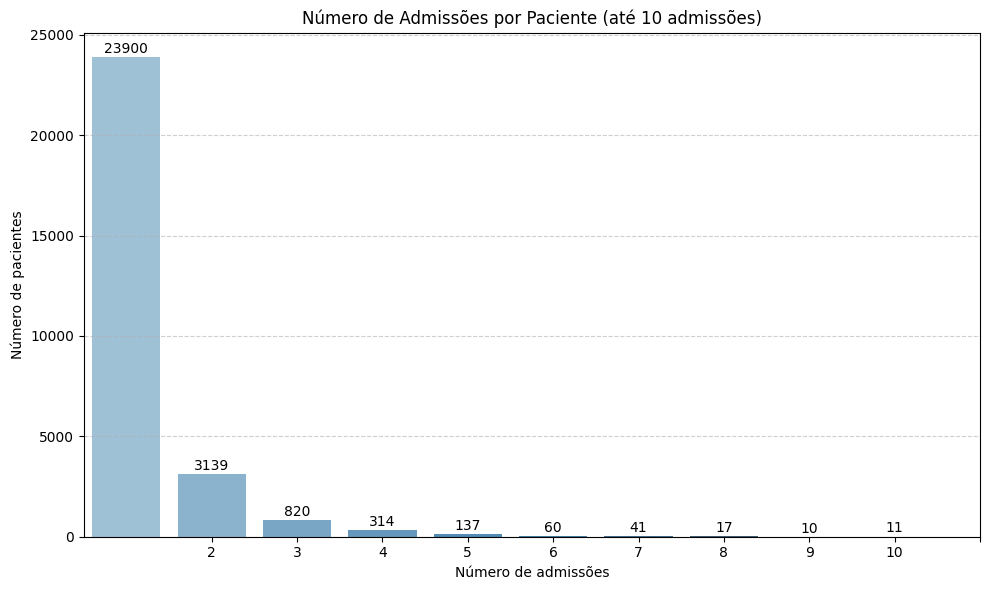

In [25]:
query = """
SELECT
  SUBJECT_ID,
  COUNT(DISTINCT HADM_ID) AS num_admissoes
FROM
  `ml-pipeline-459822.data.raw_features`
GROUP BY
  SUBJECT_ID
"""

num_admissoes = bpd.read_gbq(query).to_pandas()


# Contar número de pacientes por número de admissões
# Correção robusta com nomes explícitos
admissoes_count = num_admissoes['num_admissoes'].value_counts().sort_index()
admissoes_count = admissoes_count.reset_index()
admissoes_count.columns = ['num_admissoes', 'num_pacientes']

# Limitar aos 10 primeiros valores para melhor leitura
admissoes_count = admissoes_count[admissoes_count['num_admissoes'] <= 10]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=admissoes_count, x='num_admissoes', y='num_pacientes', palette='Blues_d')

# Adicionar rótulos nas barras
for index, row in admissoes_count.iterrows():
    plt.text(index, row['num_pacientes'] + 50, int(row['num_pacientes']), ha='center', va='bottom')

plt.title("Número de Admissões por Paciente (até 10 admissões)")
plt.xlabel("Número de admissões")
plt.ylabel("Número de pacientes")
plt.xticks(range(1, 11))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**PySpark**

In [32]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import countDistinct

# Iniciar sessão Spark
spark = SparkSession.builder \
    .appName("AdmissoesPorPaciente") \
    .getOrCreate()

# Carregar CSV (ou outro formato, por ex: Parquet)
df_spark = spark.read.csv("raw_features.csv", header=True, inferSchema=True)

# Agrupar e contar admissões únicas por paciente
admissoes_spark = df_spark.groupBy("SUBJECT_ID") \
    .agg(countDistinct("HADM_ID").alias("num_admissoes"))

# Mostrar os resultados
admissoes_spark.show(10)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/06/01 17:57:01 WARN Utils: Your hostname, MacBook-Pro-de-Alexandre.local, resolves to a loopback address: 127.0.0.1; using 172.17.16.88 instead (on interface en0)
25/06/01 17:57:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/01 17:57:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/01 17:57:03 WARN FileStreamSink: Assume no metadata directory. Error while looking for metadata directory in the path: raw_features.csv.
java.io.FileNotFoundException: File raw_features.csv does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:917)
	at

AnalysisException: [PATH_NOT_FOUND] Path does not exist: file:/Users/alexandresousa/Desktop/Projeto Big Data/big_data/raw_features.csv. SQLSTATE: 42K03

/var/folders/2t/mv0q1c7j2z97cgvtlhbfrhhm0000gn/T/ipykernel_84315/3010145359.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pacientes_por_tipo, x='ADMISSION_TYPE', y='num_pacientes', palette='Set2')


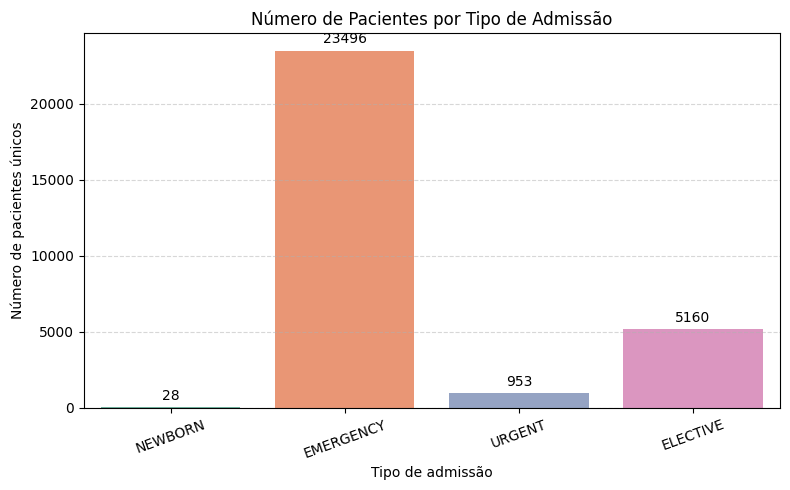

In [26]:
 # Executar a query
query = """
SELECT
  ADMISSION_TYPE,
  COUNT(DISTINCT SUBJECT_ID) AS num_pacientes
FROM
  `ml-pipeline-459822.data.raw_features`
WHERE
  ADMISSION_TYPE IS NOT NULL
GROUP BY
  ADMISSION_TYPE
ORDER BY
  num_pacientes DESC
"""
pacientes_por_tipo = bpd.read_gbq(query).to_pandas()

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(data=pacientes_por_tipo, x='ADMISSION_TYPE', y='num_pacientes', palette='Set2')

# Adicionar valores nas barras
for index, row in pacientes_por_tipo.iterrows():
    plt.text(index, row['num_pacientes'] + 500, int(row['num_pacientes']), ha='center')

plt.title("Número de Pacientes por Tipo de Admissão")
plt.xlabel("Tipo de admissão")
plt.ylabel("Número de pacientes únicos")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Número dos Tipos de Admissões

/var/folders/2t/mv0q1c7j2z97cgvtlhbfrhhm0000gn/T/ipykernel_84315/156803317.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tipos_admissao, x='ADMISSION_TYPE', y='num_admissoes', palette='Purples_d')


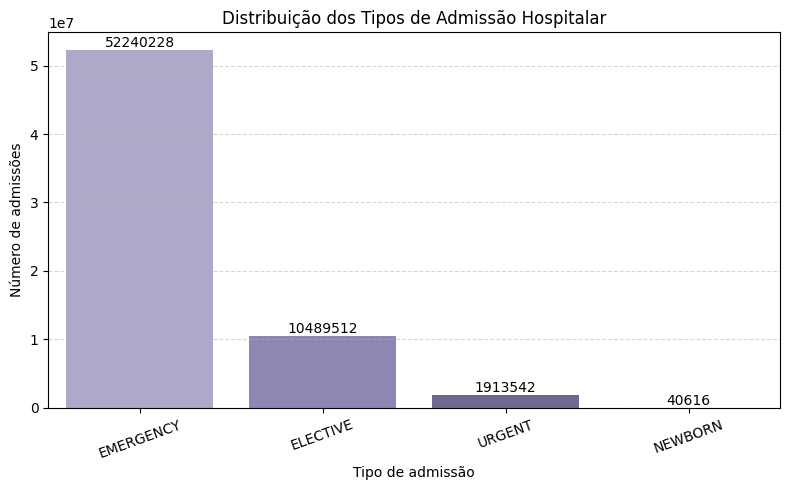

In [23]:
query="""
SELECT DISTINCT
  ADMISSION_TYPE,
  COUNT(*) AS num_admissoes
FROM
  `ml-pipeline-459822.data.raw_features`
WHERE
  ADMISSION_TYPE IS NOT NULL
GROUP BY
  ADMISSION_TYPE
ORDER BY
  num_admissoes DESC
"""

# Lê os dados da query
tipos_admissao = bpd.read_gbq(query).to_pandas()


plt.figure(figsize=(8, 5))
sns.barplot(data=tipos_admissao, x='ADMISSION_TYPE', y='num_admissoes', palette='Purples_d')

# Adicionar contagens
for index, row in tipos_admissao.iterrows():
    plt.text(index, row['num_admissoes'] + 1000, int(row['num_admissoes']), ha='center', va='bottom')

plt.title("Distribuição dos Tipos de Admissão Hospitalar")
plt.xlabel("Tipo de admissão")
plt.ylabel("Número de admissões")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Mortalidade Por Tipo de Admissão: 


/var/folders/2t/mv0q1c7j2z97cgvtlhbfrhhm0000gn/T/ipykernel_84315/3062485731.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mortalidade_admissao, x='ADMISSION_TYPE', y='taxa_mortalidade_pct', palette='Reds')


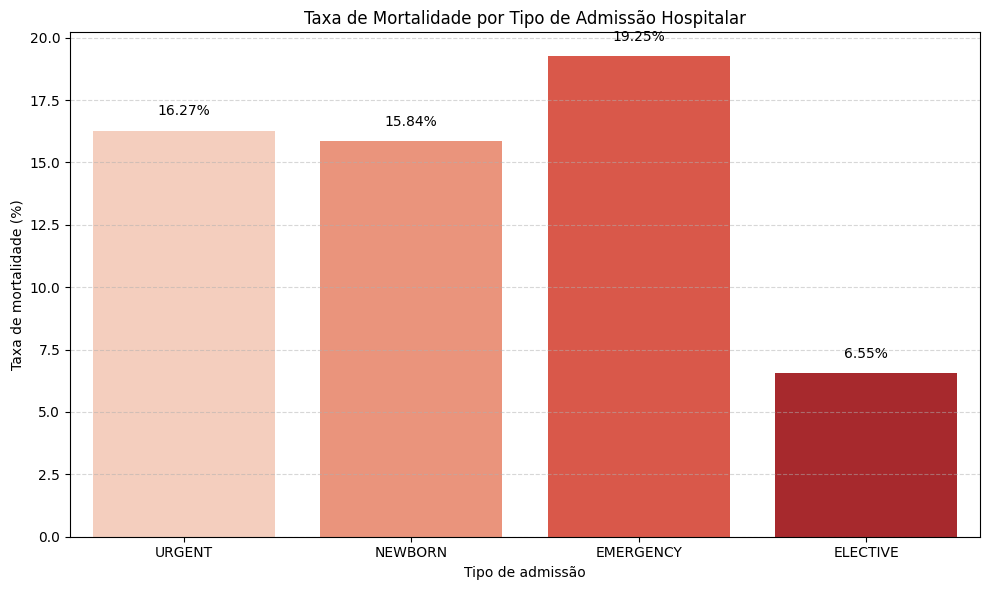

In [14]:
query="""
SELECT
  ADMISSION_TYPE,
  COUNT(*) AS num_admissoes,
  SUM(HOSPITAL_EXPIRE_FLAG) AS num_obitos,
  ROUND(SUM(HOSPITAL_EXPIRE_FLAG) / COUNT(*) * 100, 2) AS taxa_mortalidade_pct
FROM
  `ml-pipeline-459822.data.raw_features`
WHERE
  ADMISSION_TYPE IS NOT NULL
GROUP BY
  ADMISSION_TYPE
ORDER BY
  num_admissoes DESC
"""

mortalidade_admissao = bpd.read_gbq(query).to_pandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=mortalidade_admissao, x='ADMISSION_TYPE', y='taxa_mortalidade_pct', palette='Reds')

for index, row in mortalidade_admissao.iterrows():
    plt.text(index, row['taxa_mortalidade_pct'] + 0.5, f"{row['taxa_mortalidade_pct']}%", 
             ha='center', va='bottom')

plt.title("Taxa de Mortalidade por Tipo de Admissão Hospitalar")
plt.ylabel("Taxa de mortalidade (%)")
plt.xlabel("Tipo de admissão")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/var/folders/2t/mv0q1c7j2z97cgvtlhbfrhhm0000gn/T/ipykernel_84315/3257659301.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=los_admissao, x='ADMISSION_TYPE', y='media_los_dias', palette='Blues')


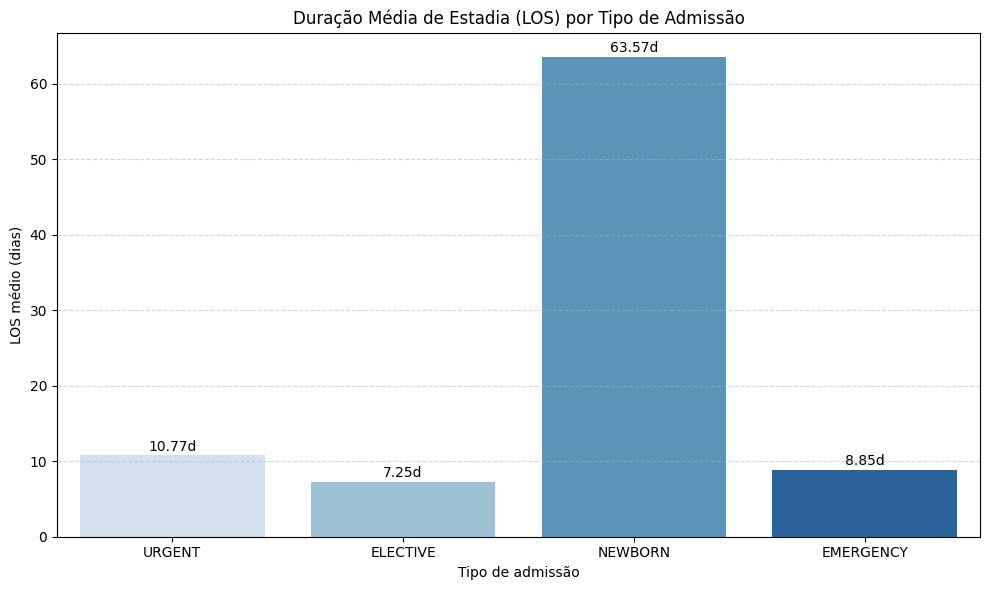

In [15]:
query="""
SELECT
  ADMISSION_TYPE,
  ROUND(AVG(LOS), 2) AS media_los_dias
FROM
  `ml-pipeline-459822.data.raw_features`
WHERE
  ADMISSION_TYPE IS NOT NULL AND LOS IS NOT NULL
GROUP BY
  ADMISSION_TYPE
ORDER BY
  media_los_dias DESC
"""

los_admissao = bpd.read_gbq(query).to_pandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=los_admissao, x='ADMISSION_TYPE', y='media_los_dias', palette='Blues')

for index, row in los_admissao.iterrows():
    plt.text(index, row['media_los_dias'] + 0.2, f"{row['media_los_dias']}d", 
             ha='center', va='bottom')

plt.title("Duração Média de Estadia (LOS) por Tipo de Admissão")
plt.ylabel("LOS médio (dias)")
plt.xlabel("Tipo de admissão")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/var/folders/2t/mv0q1c7j2z97cgvtlhbfrhhm0000gn/T/ipykernel_84315/1745098633.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=estadias_count, x='num_estadias_uci', y='num_pacientes', palette='Greens_d')


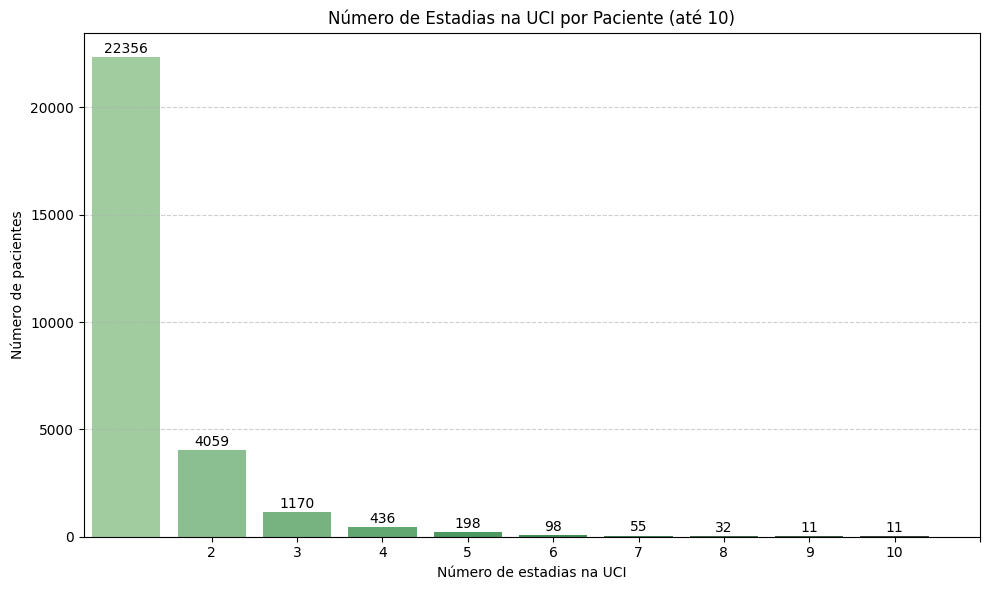

In [10]:
# Query para contar número de estadias em UCI por paciente
query_icu = """
SELECT
  SUBJECT_ID,
  COUNT(DISTINCT ICUSTAY_ID) AS num_estadias_uci
FROM
  `ml-pipeline-459822.data.raw_features`
WHERE
  ICUSTAY_ID IS NOT NULL
GROUP BY
  SUBJECT_ID
"""

num_estadias = bpd.read_gbq(query_icu).to_pandas()

# Contar número de pacientes por número de estadias
estadias_count = num_estadias['num_estadias_uci'].value_counts().sort_index()
estadias_count = estadias_count.reset_index()
estadias_count.columns = ['num_estadias_uci', 'num_pacientes']

# Limitar a 10 para visualização
estadias_count = estadias_count[estadias_count['num_estadias_uci'] <= 10]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=estadias_count, x='num_estadias_uci', y='num_pacientes', palette='Greens_d')

for index, row in estadias_count.iterrows():
    plt.text(index, row['num_pacientes'] + 50, int(row['num_pacientes']), ha='center', va='bottom')

plt.title("Número de Estadias na UCI por Paciente (até 10)")
plt.xlabel("Número de estadias na UCI")
plt.ylabel("Número de pacientes")
plt.xticks(range(1, 11))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

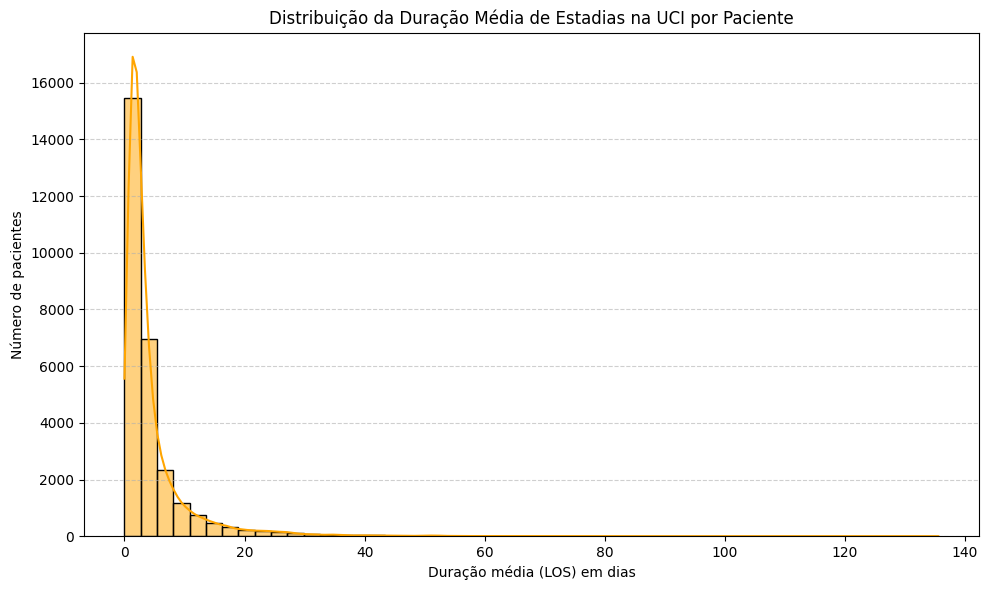

In [11]:
# Query para calcular o tempo médio de estadia (LOS) por paciente
query_los = """
SELECT
  SUBJECT_ID,
  AVG(LOS) AS media_los
FROM
  `ml-pipeline-459822.data.raw_features`
WHERE
  ICUSTAY_ID IS NOT NULL AND LOS IS NOT NULL
GROUP BY
  SUBJECT_ID
"""

media_los = bpd.read_gbq(query_los).to_pandas()

# Plot da distribuição da média de LOS
plt.figure(figsize=(10, 6))
sns.histplot(media_los['media_los'], bins=50, kde=True, color='orange')

plt.title("Distribuição da Duração Média de Estadias na UCI por Paciente")
plt.xlabel("Duração média (LOS) em dias")
plt.ylabel("Número de pacientes")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Medições Clínicas Mais Comuns (Label - D_ITEMS)

/var/folders/2t/mv0q1c7j2z97cgvtlhbfrhhm0000gn/T/ipykernel_84315/174409521.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_labels, y='LABEL', x='total_ocorrencias', palette='Blues_d')


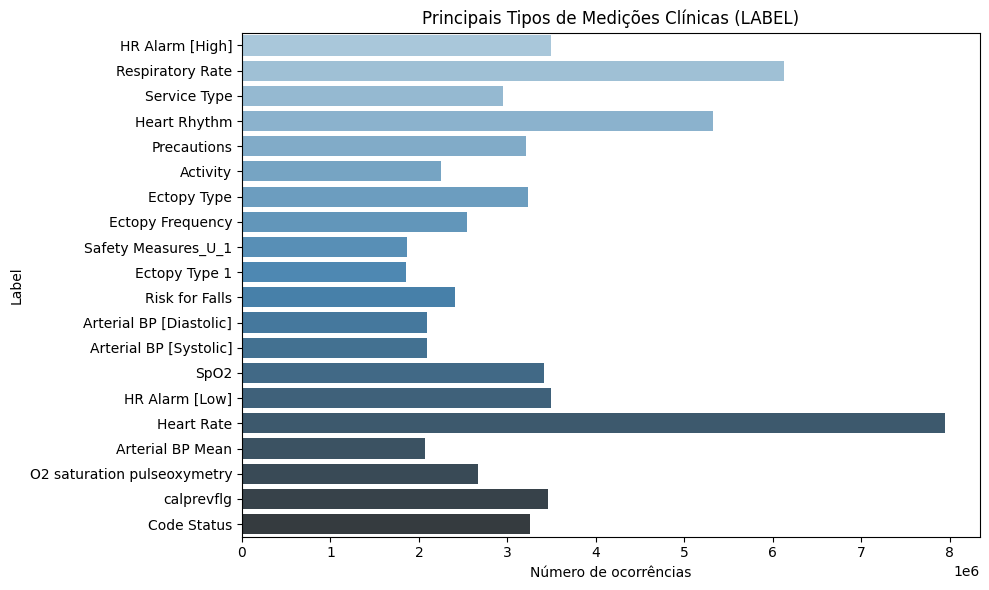

In [12]:
query = """
SELECT
  di.LABEL,
  COUNT(*) AS total_ocorrencias
FROM
  `ml-pipeline-459822.data.chartevents` AS ce
JOIN
  `ml-pipeline-459822.data.d_items` AS di
ON
  ce.ITEMID = di.ITEMID
GROUP BY
  di.LABEL
ORDER BY
  total_ocorrencias DESC
LIMIT 20
"""

top_labels = bpd.read_gbq(query).to_pandas()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_labels, y='LABEL', x='total_ocorrencias', palette='Blues_d')
plt.title("Principais Tipos de Medições Clínicas (LABEL)")
plt.xlabel("Número de ocorrências")
plt.ylabel("Label")
plt.tight_layout()
plt.show()

## Género 


/var/folders/2t/mv0q1c7j2z97cgvtlhbfrhhm0000gn/T/ipykernel_84315/1971803897.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genero_dist, x='GENDER', y='num_pacientes', palette='pastel')


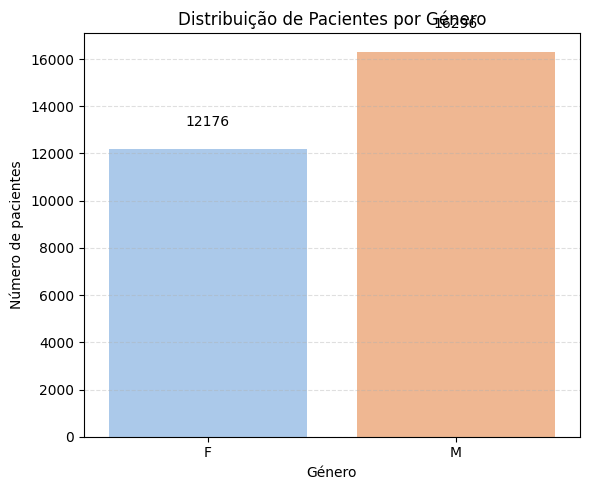

In [17]:
query="""
SELECT
  GENDER,
  COUNT(DISTINCT SUBJECT_ID) AS num_pacientes
FROM
  `ml-pipeline-459822.data.raw_features`
WHERE
  GENDER IS NOT NULL
GROUP BY
  GENDER
"""

genero_dist = bpd.read_gbq(query).to_pandas()

plt.figure(figsize=(6, 5))
sns.barplot(data=genero_dist, x='GENDER', y='num_pacientes', palette='pastel')

for index, row in genero_dist.iterrows():
    plt.text(index, row['num_pacientes'] + 1000, int(row['num_pacientes']), ha='center')

plt.title("Distribuição de Pacientes por Género")
plt.xlabel("Género")
plt.ylabel("Número de pacientes")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

**Principais Diagnósticos Por Género**

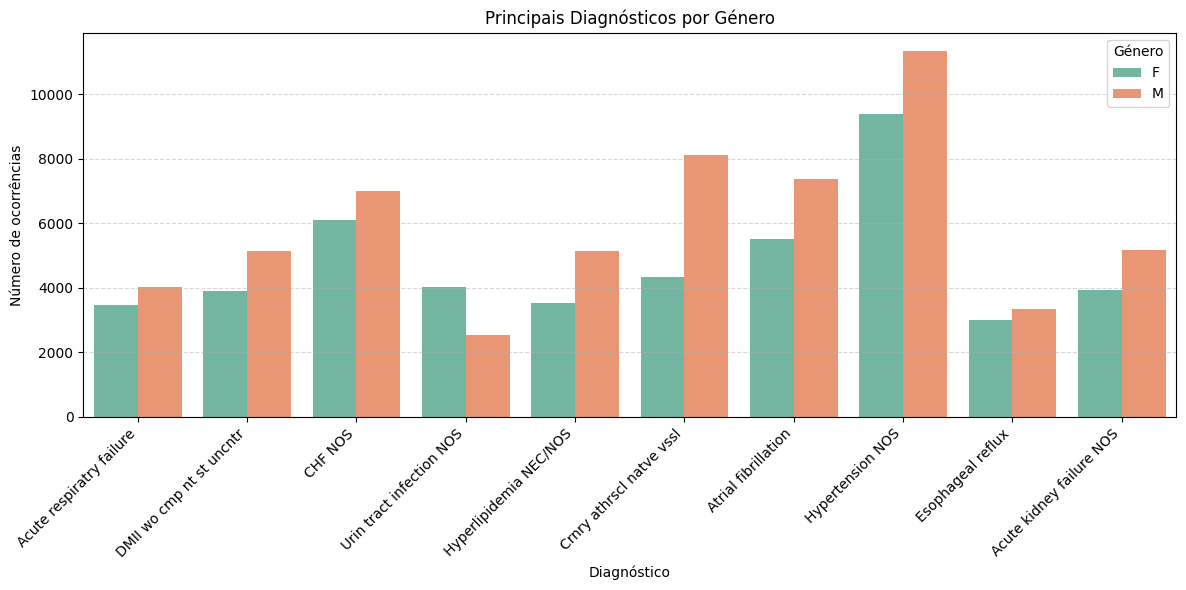

In [18]:
query="""
SELECT
  p.GENDER,
  dd.SHORT_TITLE AS diagnostico,
  COUNT(*) AS num_ocorrencias
FROM
  `ml-pipeline-459822.data.diagnoses_icd` AS d
JOIN
  `ml-pipeline-459822.data.d_icd_diagnoses` AS dd
ON
  d.ICD9_CODE = dd.ICD9_CODE
JOIN
  `ml-pipeline-459822.data.patients` AS p
ON
  d.SUBJECT_ID = p.SUBJECT_ID
WHERE
  p.GENDER IN ('M', 'F')
GROUP BY
  p.GENDER, dd.SHORT_TITLE
ORDER BY
  num_ocorrencias DESC
LIMIT 1000
"""

# Lê os dados da query
df = bpd.read_gbq(query).to_pandas()

# Filtra os 10 diagnósticos mais comuns por género
top_diagnosticos = (
    df.groupby('diagnostico')['num_ocorrencias'].sum()
    .nlargest(10)
    .index.tolist()
)

df_top = df[df['diagnostico'].isin(top_diagnosticos)]

# Gráfico
plt.figure(figsize=(12, 6))
sns.barplot(data=df_top, x='diagnostico', y='num_ocorrencias', hue='GENDER', palette='Set2')

plt.title("Principais Diagnósticos por Género")
plt.ylabel("Número de ocorrências")
plt.xlabel("Diagnóstico")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Género')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Análise Por Paciente


Agora, vamos analisar estátisticas e dados de um paciente apenas, referente a um ou vários ***icu stays***:

Vamos usar também esta secção para fazer algumas comparações de bibliotecas que lidam com base de dados maiores e técnicas de paralelismo. 

**Big Query**

In [26]:
query="""
SELECT
  rf.CHARTTIME,
  rf.VALUENUM,
  rf.LABEL,
  rf.ICUSTAY_ID
FROM
  `ml-pipeline-459822.data.raw_features` AS rf
WHERE
  rf.SUBJECT_ID = 10006
  AND rf.LABEL IN ('Heart Rate', 'SpO2', 'Respiratory Rate', 'Temperature')
  AND rf.VALUENUM IS NOT NULL
ORDER BY
  rf.CHARTTIME
"""

df = bpd.read_gbq(query).to_pandas()
query="""
SELECT
  ICUSTAY_ID,
  INTIME,
  OUTTIME
FROM
  `ml-pipeline-459822.data.icustays`
WHERE
  SUBJECT_ID = 10006
"""
tempos_uci = bpd.read_gbq(query).to_pandas().set_index('ICUSTAY_ID')


📊 Curvas temporais – Paciente 10006 – Estadia 206504


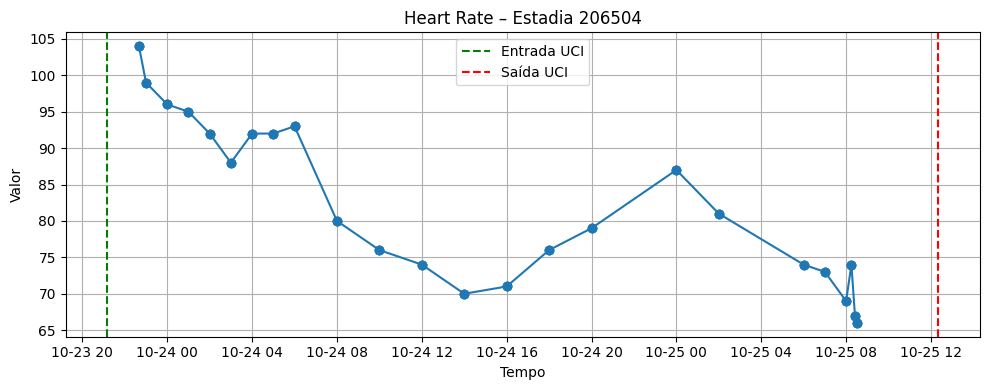

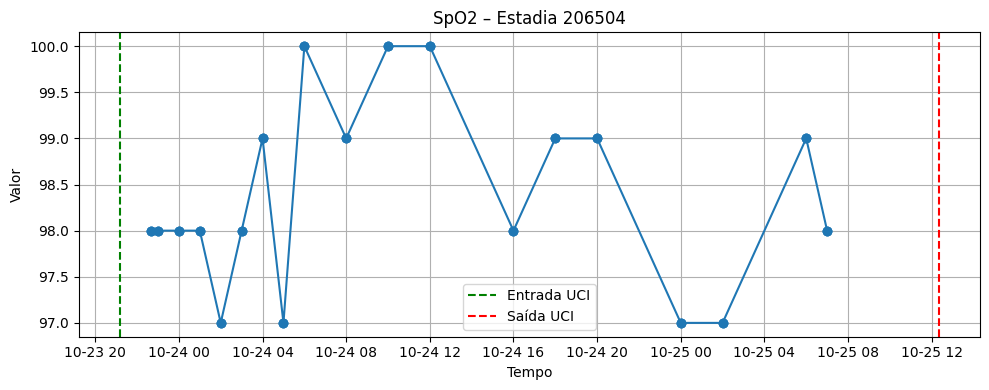

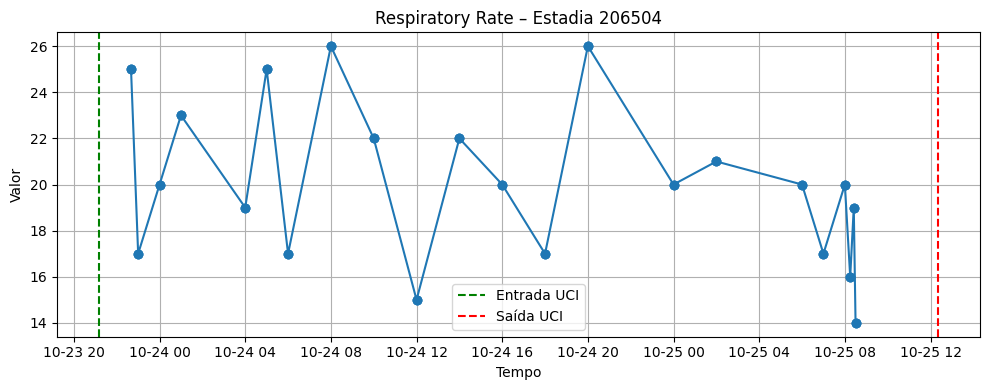

In [27]:

# Lista de métricas a mostrar
metricas = ['Heart Rate', 'SpO2', 'Respiratory Rate', 'Temperature']
subject_id = 10006
estadias_uci = df['ICUSTAY_ID'].dropna().unique()

for icu_id in estadias_uci:
    df_icu = df[(df['ICUSTAY_ID'] == icu_id) & (df['LABEL'].isin(metricas))]

    if df_icu.empty or icu_id not in tempos_uci.index:
        continue

    intime = tempos_uci.loc[icu_id, 'INTIME']
    outtime = tempos_uci.loc[icu_id, 'OUTTIME']

    print(f"\n📊 Curvas temporais – Paciente {subject_id} – Estadia {icu_id}")

    for metrica in metricas:
        dados = df_icu[df_icu['LABEL'] == metrica].sort_values('CHARTTIME')

        # Remoção de outliers
        if metrica == 'Respiratory Rate':
            dados = dados[dados['VALUENUM'] < 60]
        if metrica == 'Heart Rate':
            dados = dados[dados['VALUENUM'] < 200]

        if dados.empty:
            continue

        plt.figure(figsize=(10, 4))
        plt.plot(dados['CHARTTIME'], dados['VALUENUM'], marker='o', linestyle='-')
        plt.axvline(intime, color='green', linestyle='--', label='Entrada UCI')
        plt.axvline(outtime, color='red', linestyle='--', label='Saída UCI')
        plt.title(f"{metrica} – Estadia {icu_id}")
        plt.xlabel("Tempo")
        plt.ylabel("Valor")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

---

🔄 1. Preparação dos dados
    •    Selecionar variáveis úteis: vitais, demográficas, tipo de admissão, valores laboratoriais, etc.
    •    Remover ou imputar valores nulos
    •    Codificar variáveis categóricas (OneHot ou Label Encoding)
    •    Normalizar variáveis numéricas
    •    Definir a variável alvo: LOS (Length of Stay)

⚙️ 2. Dividir em treino/teste
    •    70% treino / 30% teste, ou usar validação cruzada

🧠 3. Treinar modelos

Comparar modelos com:
    •    scikit-learn (ex: Linear Regression, Random Forest, XGBoost)
    •    Dask-ML (ideal se fores escalar)
    •    PySpark MLlib (bom para grandes volumes distribuídos)
    •    BigQuery ML (se quiseres evitar transferência de dados e treinar diretamente na cloud)

📊 4. Avaliar modelos
    •    Métricas de regressão: MAE, RMSE, R²
    •    Comparar tempo de treino, interpretabilidade e escalabilidade

📈 5. Visualizar previsões
    •    Plot de LOS real vs previsto
    •    Curvas de erro residual

# Data Preparation
[[ go back to the top ]](#Table-of-contents)

Este é o Data Frame que vamos trabalhar e usar para a fase de prepração de dados, usando Big Frames. 

In [7]:
# 1. Ler a tabela completa
df_prep = bpd.read_gbq("ml-pipeline-459822.data.raw_features")

Passando a parte do trabalho mais ligada a *Machine Learning*, vamos, primeiro de tudo, realizar a preparação dos dados: 

Primeiramente, vamos passar a coluna 'LOS', que é aquilo que queremos prever, para o fim da tabela. 

In [8]:
# Get the list of columns, removing 'LOS'
columns = [col for col in df_prep.columns if col != 'LOS']

# Add 'LOS' to the end of the list of columns
columns.append('LOS')

print(columns)

['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'CHARTTIME', 'DOB', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG', 'ADMISSION_TYPE', 'GENDER', 'ETHNICITY', 'RELIGION', 'LANGUAGE', 'MARITAL_STATUS', 'INSURANCE', 'ITEMID', 'LABEL', 'CATEGORY', 'VALUE', 'VALUENUM', 'WARNING', 'ERROR', 'ICD9_CODE', 'SEQ_NUM', 'LOS']


In [9]:
# Get the list of columns, removing 'LOS'
columns = [col for col in df_prep.columns if col != 'LOS']

# Add 'LOS' to the end of the list of columns
columns.append('LOS')

# Reindex the DataFrame with the new order of columns
df_prep = df_prep.reindex(columns=columns)

print(df_prep)

    SUBJECT_ID  HADM_ID  ICUSTAY_ID            CHARTTIME  \
0        55507   189435      286485  2200-09-29 04:26:00   
1        70212   136830      269834  2119-11-04 15:52:00   
2        21454   115782      265264  2165-06-25 18:00:00   
3        12012   143160      280468  2162-07-03 14:00:00   
4         1006   108462      255796  2159-08-28 07:00:00   
5        14321   151860      296709  2119-09-14 15:00:00   
6        22984   104849      267932  2123-02-28 01:00:00   
7        57642   131270      259835  2152-08-14 12:00:00   
8        27703   109449      202862  2168-10-20 23:00:00   
9        14060   171645      226191  2178-06-08 12:48:00   
10       18846   188344      266604  2136-08-28 16:00:00   
11       84585   182054      245641  2100-08-03 16:00:00   
12       24386   124911      205768  2132-08-17 19:00:00   
13       95308   178687      233895  2176-07-26 19:00:00   
14       21769   133364      247886  2204-01-14 17:29:00   
15       25672   164737      257949  212

**Valores Nulos**

In [10]:


# Verificar a quantidade de valores nulos por coluna
missing_values = df_prep.isnull().sum()

# Calcular a porcentagem de valores nulos por coluna
missing_percentage = (missing_values / len(df_prep)) * 100

# Combinar as informações em um DataFrame para melhor visualização
missing_data = pd.DataFrame({
    'Valores Nulos': missing_values,
    'Porcentagem (%)': missing_percentage,
    'Tipo de Dado': df_prep.dtypes
})

# Exibir as colunas com valores nulos
missing_data = missing_data[missing_data['Valores Nulos'] > 0]
print(missing_data.sort_values(by='Porcentagem (%)', ascending=False))

                Valores Nulos  Porcentagem (%)                    Tipo de Dado
DEATHTIME           322990326        79.508072  timestamp[us, tz=UTC][pyarrow]
WARNING             244699759        60.235879                           Int64
ERROR               244699759        60.235879                           Int64
CATEGORY            231786720        57.057174                 string[pyarrow]
VALUENUM            223935703        55.124549                         Float64
LANGUAGE            147914535        36.410996                 string[pyarrow]
MARITAL_STATUS       18661087         4.593658                 string[pyarrow]
RELIGION              2693777         0.663107                 string[pyarrow]
VALUE                 2526502         0.621930                 string[pyarrow]
ICUSTAY_ID             261508         0.064373                           Int64
LOS                    261508         0.064373                         Float64


Aqui está uma estimativa aproximada da percentagem de valores em falta para algumas colunas:

DEATHTIME: ~80%

WARNING: 60%

ERROR: 60%

LANGUAGE: ~36%


Eliminar as colunas, com alta percentagem de valores nulos: (verificar se é efetivamente isso que queremos a fazer)


**AGE**

A idade é uma das variáveis que consideramos importante ao prever o tempo de permanência de um paciente na Unidade de Cuidados Intensivos.
Porém, segundo a documentação existem valores de idade acima dos 300 anos, pelo que estes valores precisam de ser filtrado. 
300 = 90 
301 = 91
(...)

In [13]:
df_prep['AGE'] = df_prep['ADMITTIME'].dt.year - df_prep['DOB'].dt.year
df_prep = df_prep.assign(
    AGE = df_prep['AGE'].where(df_prep['AGE'] < 300, df_prep['AGE'] - 300 + 90)
)
df_prep = df_prep.drop(columns=['ADMITTIME', 'DOB'])


KeyError: "ADMITTIME not found in DataFrame columns: Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'CHARTTIME', 'DISCHTIME',\n       'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG', 'ADMISSION_TYPE', 'GENDER',\n       'ETHNICITY', 'RELIGION', 'LANGUAGE', 'MARITAL_STATUS', 'INSURANCE',\n       'ITEMID', 'LABEL', 'CATEGORY', 'VALUE', 'VALUENUM', 'WARNING', 'ERROR',\n       'ICD9_CODE', 'SEQ_NUM', 'LOS', 'AGE'],\n      dtype='object')"

**Valores duplicados**:

In [14]:
duplicados = df_prep[df_prep.duplicated()]
print(f"Número de linhas duplicadas: {len(duplicados)}")

Número de linhas duplicadas: 0


**Verificar colunas categóricas**

In [15]:

string_cols = [col for col, dtype in zip(df_prep.columns, df_prep.dtypes) if dtype == "string"]

for col in string_cols:
    count = df_prep[col].nunique()
    print(f"{col}: {count} valores distintos")

ADMISSION_TYPE: 4 valores distintos
GENDER: 2 valores distintos
ETHNICITY: 41 valores distintos
RELIGION: 20 valores distintos
LANGUAGE: 69 valores distintos
MARITAL_STATUS: 7 valores distintos
INSURANCE: 5 valores distintos
LABEL: 4559 valores distintos
CATEGORY: 56 valores distintos
VALUE: 268260 valores distintos
ICD9_CODE: 5 valores distintos


Vamos agora retirar as colunas com string e não deverão ter relevância para a tarefa de classificação vingente

In [16]:
# 2. Remover colunas indesejadas
colunas_a_remover = ['RELIGION', 'ETHNICITY', 'LANGUAGE', 'MARITAL_STATUS', 'INSURANCE']
df_prep = df_prep.drop(columns=colunas_a_remover)



Passar a coluna gender para: 
    
M -> 1

F -> 0

In [ ]:
print(df_prep.dtypes)

SUBJECT_ID                                       Int64
HADM_ID                                          Int64
ICUSTAY_ID                                       Int64
CHARTTIME                       timestamp[us][pyarrow]
DOB                     timestamp[us, tz=UTC][pyarrow]
ADMITTIME               timestamp[us, tz=UTC][pyarrow]
DISCHTIME               timestamp[us, tz=UTC][pyarrow]
DEATHTIME               timestamp[us, tz=UTC][pyarrow]
HOSPITAL_EXPIRE_FLAG                             Int64
ADMISSION_TYPE                         string[pyarrow]
GENDER                                           Int64
ETHNICITY                              string[pyarrow]
RELIGION                               string[pyarrow]
LANGUAGE                               string[pyarrow]
MARITAL_STATUS                         string[pyarrow]
INSURANCE                              string[pyarrow]
ITEMID                                           Int64
LABEL                                  string[pyarrow]
VALUE     

In [17]:

df_prep["GENDER"] = df_prep["GENDER"].map({"F": 0, "M": 1})



In [18]:
df_prep['GENDER'].head()

0    0
1    1
2    0
3    1
4    1
Name: GENDER, dtype: Int64

Como a tabela 'LABEL' tem vários valores distintos, eles estão organizados em categorias na coluna 'CATEGORY', então basta-nos ter esta coluna como relevante. 

In [19]:
df_prep["CATEGORY"].head(10)

0                     Alarms
1    Cardiovascular (Pulses)
2                       <NA>
3                       <NA>
4                       <NA>
5                       <NA>
6                       <NA>
7                 Treatments
8                       <NA>
9                       Labs
Name: CATEGORY, dtype: string

O problema que esta coluna é um número muito maior de valores nulos. 

-------

## Dividir os conjunto de Dados Em Treino e Teste

**Big Frames**

In [20]:
# Ordenar o DataFrame pelo tempo
df_sorted = df_prep.sort_values("INTIME")

# Contar número total de linhas
row_count = df_sorted.shape[0].compute()
print("Número de linhas do data set após a fase de preparação de dados:", row_count)

# Calcular índice de divisão (80%)
split_index = int(row_count * 0.8)

# Fazer a divisão temporal
df_train = df_sorted.iloc[:split_index]
df_test = df_sorted.iloc[split_index:]

ValueError: Column name INTIME doesn't exist

--------

In [ ]:
def split_data(bf_df, test_size=0.2, val_size=0.1):
    """
    Splits the data into training, validation, and testing sets.

    Args:
        bf_df: BigFrame DataFrame.
        test_size (float): Proportion of the dataset to include in the test split.
        val_size (float): Proportion of the dataset to include in the validation split.

    Returns:
        tuple: Three DataFrames containing the training, validation, and testing sets.
    """
    df = bf_df.to_pandas()  # Convert BigFrame to pandas DataFrame for processing
    unique_subject_ids = df['SUBJECT_ID'].unique()

    train_ids, test_ids = train_test_split(unique_subject_ids, test_size=test_size)
    train_ids, val_ids = train_test_split(train_ids, test_size=val_size / (1 - test_size))

    train_df = df[df['SUBJECT_ID'].isin(train_ids)]
    val_df = df[df['SUBJECT_ID'].isin(val_ids)]
    test_df = df[df['SUBJECT_ID'].isin(test_ids)]

    return train_df, val_df, test_df

def preprocess_data(bf_df):
    """
    Preprocesses the data by converting it to a pandas DataFrame, performing feature engineering,
    and converting it back to BigFrame.

    Args:
        bf_df: BigFrame DataFrame.

    Returns:
        bf.DataFrame: Preprocessed BigFrame DataFrame.
    """
    df = bf_df.to_pandas()

    df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME']).astype(int)
    df['DEATHTIME'] = df['DEATHTIME'].replace('unknown', pd.NaT)
    df['DEATHTIME'] = pd.to_datetime(df['DEATHTIME']).astype(int)

    df = pd.get_dummies(df, columns=['ADMISSION_TYPE', 'GENDER', 'ETHNICITY', 'RELIGION', 'LANGUAGE', 'MARITAL_STATUS', 'INSURANCE', 'LABEL', 'ERROR', 'DBSOURCE', 'SHORT_TITLE', 'VALUE'])

    df['SUBJECT_ID'] = df['SUBJECT_ID'].astype(int)
    df['HADM_ID'] = df['HADM_ID'].astype(int)
    df['ICUSTAY_ID'] = df['ICUSTAY_ID'].astype(int)
    df['ITEMID'] = df['ITEMID'].astype(int)
    df['ICD9_CODE'] = df['ICD9_CODE'].astype(int)
    df['SEQ_NUM'] = df['SEQ_NUM'].astype(int)
    df['AGE'] = df['AGE'].astype(int)

    return bf.from_pandas(df)

# Preprocess the data
preprocessed_bf = preprocess_data(bigframe)

# Convert preprocessed BigFrame to pandas DataFrame for further processing
preprocessed_df = preprocessed_bf.to_pandas()

# Split the data into training, validation, and testing sets
train_df, val_df, test_df = split_data(preprocessed_df)

# Extract features and target variable for training
X_train = train_df.iloc[:, :-1]
y_train = train_df['LOS']

# Extract features and target variable for validation
X_val = val_df.iloc[:, :-1]
y_val = val_df['LOS']

# Extract features and target variable for testing
X_test = test_df.iloc[:, :-1]
y_test = test_df['LOS']

# Fit a linear regression model on the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Cross-validation to evaluate the model on the validation set
mse_scores = cross_val_score(model, X_val, y_val, scoring='neg_mean_squared_error', cv=5)
mse_mean = -mse_scores.mean()
print('Mean Squared Error on Validation Set (Cross-Validation):', mse_mean)

# Evaluate the model on the test set
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
print('Mean Squared Error on Test Set:', mse_test)

KeyError: "['SHORT_TITLE'] not in index"

In [ ]:
def split_data(df, test_size=0.2, val_size=0.1):
    """
    Splits the data into training, validation, and testing sets.

    Args:
        df (DataFrame): DataFrame containing the dataset.
        test_size (float): Proportion of the dataset to include in the test split.
        val_size (float): Proportion of the dataset to include in the validation split.

    Returns:
        tuple: Three DataFrames containing the training, validation, and testing sets.
    """
    unique_subject_ids = df['SUBJECT_ID'].unique()

    train_ids, test_ids = train_test_split(unique_subject_ids, test_size=test_size)
    train_ids, val_ids = train_test_split(train_ids, test_size=val_size / (1 - test_size))

    train_df = df[df['SUBJECT_ID'].isin(train_ids)]
    val_df = df[df['SUBJECT_ID'].isin(val_ids)]
    test_df = df[df['SUBJECT_ID'].isin(test_ids)]

    return train_df, val_df, test_df

def preprocess_data(df):
    """
    Preprocesses the data by converting it to a pandas DataFrame, performing feature engineering,
    and converting it back to BigFrame.

    Args:
        df (DataFrame): DataFrame containing the dataset.

    Returns:
        DataFrame: Preprocessed DataFrame.
    """
    df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME']).astype(int)

    df['DEATHTIME'] = df['DEATHTIME'].replace('unknown', pd.NaT)

    df['DEATHTIME'] = pd.to_datetime(df['DEATHTIME']).astype(int)

    df = pd.get_dummies(df, columns=['ADMISSION_TYPE', 'GENDER', 'ETHNICITY', 'RELIGION', 'LANGUAGE', 'MARITAL_STATUS', 'INSURANCE', 'LABEL', 'ERROR', 'DBSOURCE', 'SHORT_TITLE', 'VALUE'])

    df['SUBJECT_ID'] = df['SUBJECT_ID'].astype(int)
    df['HADM_ID'] = df['HADM_ID'].astype(int)
    df['ICUSTAY_ID'] = df['ICUSTAY_ID'].astype(int)
    df['ITEMID'] = df['ITEMID'].astype(int)
    df['ICD9_CODE'] = df['ICD9_CODE'].astype(int)
    df['SEQ_NUM'] = df['SEQ_NUM'].astype(int)
    df['AGE'] = df['AGE'].astype(int)

    return df

# Preprocess the data
preprocessed_df = preprocess_data(dask_df.compute())

# Split the data into training, validation, and testing sets
train_df, val_df, test_df = split_data(preprocessed_df)

# Extract features and target variable for training
X_train = train_df.iloc[:, :-1]
y_train = train_df['LOS']

# Extract features and target variable for validation
X_val = val_df.iloc[:, :-1]
y_val = val_df['LOS']

# Extract features and target variable for testing
X_test = test_df.iloc[:, :-1]
y_test = test_df['LOS']

# Fit a linear regression model on the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Cross-validation to evaluate the model on the validation set
mse_scores = cross_val_score(model, X_val, y_val, scoring='neg_mean_squared_error', cv=5)
mse_mean = -mse_scores.mean()
print('Mean Squared Error on Validation Set (Cross-Validation):', mse_mean)

# Evaluate the model on the test set
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
print('Mean Squared Error on Test Set:', mse_test)

NameError: name 'dask_df' is not defined

# Test

In [ ]:
agg = raw_features.groupby(['ICUSTAY_ID', 'LABEL'])['VALUENUM'].agg(['mean', 'min', 'max', 'std']).reset_index()
pivot = agg.pivot(index='ICUSTAY_ID', columns='LABEL', values='mean')  # example for 'mean'

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = df.drop(columns=['LOS'])
y = df['LOS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_jobs=-1)  # parallelism
model.fit(X_train, y_train)
preds = model.predict(X_test)

print("RMSE:", mean_squared_error(y_test, preds, squared=False))


BadRequest: 400 GET https://bigquery.googleapis.com/bigquery/v2/projects/ml-pipeline-459822/queries/job_JsW0uLDvQCmkZsjGezQ-Mw971hG8?maxResults=0&location=europe-west3&prettyPrint=false: Bad double value: ELECTIVE

Location: europe-west3
Job ID: job_JsW0uLDvQCmkZsjGezQ-Mw971hG8
